In [2]:
    !pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/c7/ef/925617d36c08e0bbdf4347a9b38974ce7ab8fdb5d1a5cf0e3f3c65ea43da/prophet-1.1.7-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/e5/77/e9e0920d17b5f91b32fcfd55c9e0f4e5e9e95acf7f134b8c204ff16c7cc1/holidays-0.77-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/46.4 kB ? eta -:--:--
     ---------------------------------------- 46.4/46.4 kB 2.3 MB/s eta 0:00:00
  Obtaining dependency information for importlib_resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
 

In [4]:
# ================================================
# Milestone 4: Advanced Forecasting
# ================================================

# STEP 0: Imports

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt

# ================================================
# STEP 1: Load and Prepare Data
# ================================================

# Paths to milestone1 datasets
orders_path = "olist_orders_dataset.csv"
order_items_path = "olist_order_items_dataset.csv"
products_path = "olist_products_dataset.csv"

# Read CSVs
orders = pd.read_csv(orders_path, parse_dates=['order_purchase_timestamp'])
items = pd.read_csv(order_items_path)
products = pd.read_csv(products_path)

# Merge to connect orders -> items -> products
merged = items.merge(orders, on="order_id", how="left")
merged = merged.merge(products, on="product_id", how="left")

# Keep only necessary columns
df = merged[['order_purchase_timestamp', 'product_category_name']]

# Drop missing categories
df = df.dropna(subset=['product_category_name'])

# Aggregate daily demand per product category
daily = (
    df.groupby([df['order_purchase_timestamp'].dt.date, 'product_category_name'])
    .size()
    .reset_index(name='demand')
)
daily.rename(columns={'order_purchase_timestamp':'date'}, inplace=True)
daily['date'] = pd.to_datetime(daily['date'])

print("Data prepared. Example:")
print(daily.head())


Data prepared. Example:
        date product_category_name  demand
0 2016-09-04      moveis_decoracao       2
1 2016-09-05             telefonia       1
2 2016-09-15          beleza_saude       3
3 2016-10-02                 bebes       1
4 2016-10-03            brinquedos       1


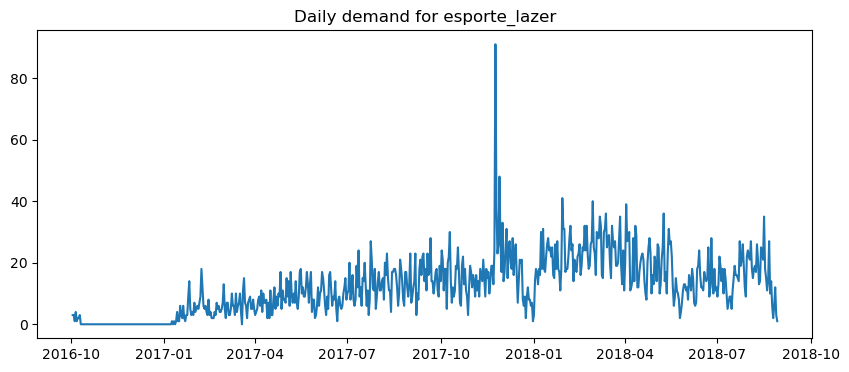

In [5]:
# ================================================
# STEP 2: Select Category for Forecasting
# ================================================
category = "esporte_lazer"  # you can change this later
cat_data = daily[daily['product_category_name'] == category]

# Aggregate daily demand
cat_data = cat_data.groupby('date')['demand'].sum().reset_index()
cat_data = cat_data.set_index('date').asfreq('D').fillna(0)

plt.figure(figsize=(10,4))
plt.plot(cat_data.index, cat_data['demand'])
plt.title(f"Daily demand for {category}")
plt.show()


In [6]:
# ================================================
# STEP 3: Train XGBoost Model
# ================================================

def create_lag_features(data, n_lags=7):
    df_lag = data.copy()
    for i in range(1, n_lags+1):
        df_lag[f'lag_{i}'] = df_lag['demand'].shift(i)
    return df_lag.dropna()

supervised = create_lag_features(cat_data, n_lags=7)

# Split into train and test (last 30 days test)
train = supervised.iloc[:-30]
test = supervised.iloc[-30:]

X_train, y_train = train.drop('demand', axis=1), train['demand']
X_test, y_test = test.drop('demand', axis=1), test['demand']

model_xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train, y_train)

pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = mean_squared_error(y_test, pred_xgb, squared=False)
r2_xgb = r2_score(y_test, pred_xgb)

print("=== XGBoost Performance ===")
print(f"MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.2f}")


=== XGBoost Performance ===
MAE: 7.03, RMSE: 8.54, R2: -0.14


23:03:57 - cmdstanpy - INFO - Chain [1] start processing
23:03:59 - cmdstanpy - INFO - Chain [1] done processing


=== Prophet Performance ===
MAE: 5.52, RMSE: 7.23, R2: 0.19


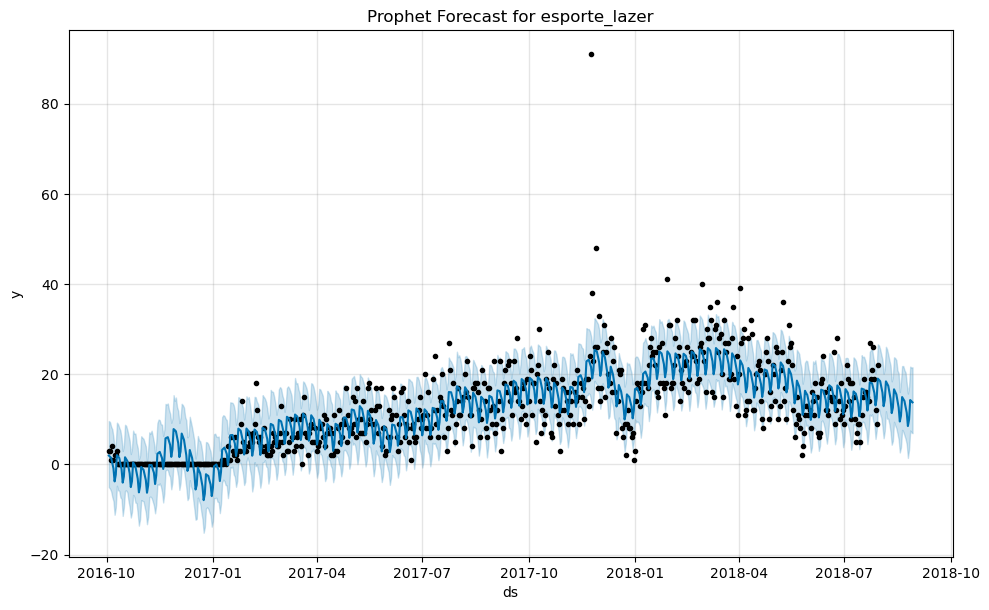

In [7]:
# ================================================
# STEP 4: Train Prophet Model
# ================================================
prophet_df = cat_data.reset_index()[['date','demand']].rename(columns={'date':'ds','demand':'y'})

train_p = prophet_df.iloc[:-30]
test_p = prophet_df.iloc[-30:]

model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
model_prophet.fit(train_p)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

pred_prophet = forecast.set_index('ds').loc[test_p['ds'], 'yhat']

mae_prophet = mean_absolute_error(test_p['y'], pred_prophet)
rmse_prophet = mean_squared_error(test_p['y'], pred_prophet, squared=False)
r2_prophet = r2_score(test_p['y'], pred_prophet)

print("=== Prophet Performance ===")
print(f"MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}, R2: {r2_prophet:.2f}")

# Plot Prophet forecast
model_prophet.plot(forecast)
plt.title(f"Prophet Forecast for {category}")
plt.show()


In [8]:
# ================================================
# STEP 5: Choose Best Model
# ================================================
if rmse_xgb < rmse_prophet:
    best_model = "XGBoost"
else:
    best_model = "Prophet"

print(f"Best model based on RMSE: {best_model}")


Best model based on RMSE: Prophet


In [10]:
# ================================================
# STEP 6: Save Models
# ================================================
# Save XGBoost
joblib.dump(model_xgb, "xgboost_model.pkl")

import pickle

with open("prophet_model.pkl", "wb") as f:
    pickle.dump(model_prophet, f)


print("Models saved in milestone4 folder.")


Models saved in milestone4 folder.
